## Preprocessing Script

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import jsonlines
import glob
from tqdm.auto import tqdm
from transformers import AutoTokenizer

2023-03-06 08:18:56.060693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 08:18:57.007420: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-06 08:18:57.007533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-06 08:18:57.007545: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
fnames = glob.glob('../data_large/pantip-large/*.jsonl')
len(fnames)

72

In [3]:
%%time

content_dfs = []
comment_dfs = []
for fname in tqdm(fnames):
    with jsonlines.open(fname) as reader:
        for obj in tqdm(reader):
            if 'comment' in obj.keys():
                d = {
                    'datasource_url': obj['datasource_url'],
                    'content_id': obj['content_id'],
                    'comment_id': obj['comment_id'],
                    'order_comment': obj['order_comment'],
                    'type':obj['type'],
                    'comment': obj['comment'],
                    'like_score': obj['like_score'],
                    'feel_heart': obj['feel_heart'],
                    'feel_laugh': obj['feel_laugh'],
                    'feel_love': obj['feel_love'],
                    'feel_sad': obj['feel_sad'],
                    'feel_horror': obj['feel_horror'],
                    'feel_wow': obj['feel_wow'],
                }
                comment_dfs.append(d)
            elif ('content' in obj.keys()) and (obj['total_field'] > 1):
                d = {
                    'datasource_url': obj['datasource_url'],
                    'content_id': obj['content_id'],
                    'type':obj['type'],
                    'title': obj['title'],
                    'body': obj['content'],
                    'total_field': obj['total_field'],
                    'tags': obj['tags'],
                    'like_score': obj['like_score'],
                    'feel_heart': obj['feel_heart'],
                    'feel_laugh': obj['feel_laugh'],
                    'feel_love': obj['feel_love'],
                    'feel_sad': obj['feel_sad'],
                    'feel_horror': obj['feel_horror'],
                    'feel_wow': obj['feel_wow'],
                }
                content_dfs.append(d)    

comment_df = pd.DataFrame(comment_dfs)
content_df = pd.DataFrame(content_dfs)

In [4]:
content_df = content_df.drop_duplicates()
#remove threads with different snapshots
content_df['rnk'] = content_df.sort_values(['total_field',],ascending=[False]) \
             .groupby(['content_id']) \
             .cumcount() + 1
content_df = content_df[content_df.rnk==1]
content_df.to_csv('../data_large/content_df.csv', index=None)


comment_df = comment_df.drop_duplicates()
comment_df['rnk'] = comment_df.groupby(['content_id','comment_id']).cumcount() + 1
comment_df = comment_df[comment_df.rnk==1]
comment_df.to_csv('../data_large/comment_df.csv', index=None)


comment_df = pd.read_csv('../data_large/comment_df.csv')
content_df = pd.read_csv('../data_large/content_df.csv')

In [5]:
#check if content deduplicated successfully
content_df.shape, content_df.content_id.nunique(), content_df.drop_duplicates().shape

In [ ]:
#check if comment deduplicated successfully
comment_df.shape, comment_df.comment_id.nunique(), comment_df.drop_duplicates().shape

In [74]:
all_df = content_df.merge(comment_df, on='content_id')
all_df = all_df.drop(['rnk_x','rnk_y','datasource_url_y'],1)
filter out later sub-comments
all_df = all_df[all_df.order_comment.map(lambda x: '-' not in str(x))]
create interact count
all_df['nb_interact'] = all_df[['like_score_y',
       'feel_heart_y', 'feel_laugh_y', 'feel_love_y', 'feel_sad_y',
       'feel_horror_y', 'feel_wow_y']].sum(1)

only keep top 5 comments with highest interacts
all_df['rnk'] = all_df.sort_values(['nb_interact','like_score_y','feel_heart_y'], \
             ascending=False) \
             .groupby(['content_id']) \
             .cumcount() + 1
all_df = all_df[all_df.rnk<=5].drop('rnk',1)

#filter less than 2 comment
all_df = all_df[all_df.total_field>1]

#pick only question in title
question_signals = ['ใคร',
                    'ทำไม',
                    'อะไร',
                    'ไหน',
                    'ไหม','มั้ย',
                    'เท่าไร','ไหร่','กี่',
                    'อย่างไร','ยังไง',
                    'หรือ','หรอ','เรอะ']
all_df = all_df[all_df.title.map(lambda x: sum(i in x for i in question_signals)>0)]

#remove edit artifacts
all_df['title'] = all_df.title.map(lambda x: x.split('แก้ไขข้อความเมื่อ')[0])
all_df['body'] = all_df.body.map(lambda x: x.split('แก้ไขข้อความเมื่อ')[0])
all_df['comment'] = all_df.comment.map(lambda x: x.split('แก้ไขข้อความเมื่อ')[0])

#replace URL
import re
def replace_url(text): return re.sub(r'http\S+|www\S+', '[URL]', text)

all_df['title'] = all_df.title.map(replace_url)
all_df['body'] = all_df.body.map(replace_url)
all_df['comment'] = all_df.comment.map(replace_url)

#remove spoiler tags
all_df['body'] = all_df.body.map(lambda x: str(x).replace('[Spoil] คลิกเพื่อดูข้อความที่ซ่อนไว้',''))
all_df['comment'] = all_df.comment.map(lambda x: str(x).replace('[Spoil] คลิกเพื่อดูข้อความที่ซ่อนไว้',''))

#drop na
all_df = all_df.dropna()

count tokens
tokenizer_mgpt = AutoTokenizer.from_pretrained('sberbank-ai/mGPT')

#title
title_tokens = tokenizer_mgpt(all_df.title.tolist())
all_df['title_tokens'] = [len(i) for i in title_tokens.input_ids]

#body
batch_size = 100_000
toks = []
for i in tqdm(range(0, len(all_df), batch_size)):
    body_tokens = tokenizer_mgpt(all_df.body.tolist()[i:i+batch_size])
    toks+= [len(i) for i in body_tokens.input_ids]
all_df['body_tokens'] = toks

#comment
batch_size = 100_000
toks = []
for i in tqdm(range(0, len(all_df), batch_size)):
    comment_tokens = tokenizer_mgpt(all_df.comment.tolist()[i:i+batch_size])
    toks+= [len(i) for i in comment_tokens.input_ids]
all_df['comment_tokens'] = toks

#filter comments
#min tok 12 (10th percentile) to filter out ขอบคุณ
#max tok 512 (97th percentile) to filter out too detailed answers
all_df = all_df[(all_df.comment_tokens>=12)&(all_df.comment_tokens<=512)]

#filter title
#min tok 16 (5th percentile) to filter out super short titles e.g. ทำไม?
#max tok 75 (99th percentile) to filter out too long titles with too many special characters/emojis
all_df = all_df[(all_df.title_tokens>=12)&(all_df.title_tokens<=75)]

#filter prompt
#min tok 48 (5th percentile) to filter out questions that are too random
#max tok 512 (90th percentile) just to fit 1024 prompt+demo
all_df = all_df[(all_df.prompt_tokens>=48)&(all_df.prompt_tokens<=512)]

#filter out thread with less than 2 comments
more_than_one = all_df.content_id.value_counts().reset_index()
more_than_one = more_than_one[more_than_one.content_id>1]
more_than_one.columns = ['content_id','nb_comments']
all_df = all_df.merge(more_than_one,on='content_id',how='inner')

#sort by nb_interact then comment_tokens; topmost has label 1, otherwise 0
all_df['rnk'] = all_df.sort_values(['nb_interact','comment_tokens'], ascending=[False,False]) \
             .groupby(['content_id']) \
             .cumcount() + 1
all_df['preference_label'] = all_df['rnk'].map(lambda x: 1 if x==1 else 0)

#add strict labels for only threads that top comments indeed have more interacts (not just longer, no ties)
rank_1 = all_df[all_df.rnk==1][['content_id','title','body','comment','nb_interact']]
rank_2 = all_df[all_df.rnk==2][['content_id','comment','nb_interact']]
rank_combined = rank_1.merge(rank_2, on='content_id')
rank_combined['strict'] = 1
rank_combined = rank_combined[rank_combined.nb_interact_x>rank_combined.nb_interact_y]
rank_combined = rank_combined[['content_id','strict']]
all_df = all_df.merge(rank_combined, on='content_id',how='left')
all_df['strict'] = all_df.strict.fillna(0)

all_df.to_csv('../data_large/all_df.csv', index=None)
all_df.shape, all_df.content_id.nunique()

((3510036, 34), 935910)

In [81]:
#load from save
all_df = pd.read_csv('../data_large/all_df.csv')

In [82]:
all_df.shape, all_df.content_id.nunique()

((3510036, 34), 935910)

## Package as Dataset

In [327]:
#save to jsonl
import json

with open('../data_large/php_json/php_universe.jsonl', 'w', encoding='utf-8') as f:
    for content_id in tqdm(all_df.content_id.unique()):
        d = all_df[all_df.content_id==content_id].sort_values('preference_label', ascending=False)
        thread_d = d[[
        'content_id','tags','nb_comments',
        'title_tokens','body_tokens','title','body','strict'
        ]].drop_duplicates().to_dict(orient='records')[0]
        comments = []
        for i,row in d.iterrows():
            comment_d = row[[
                'order_comment',
                'comment_tokens',
                'comment',
                'preference_label',
                'nb_interact']].to_dict()
            comments.append(comment_d)
        thread_d['comments'] = comments
        
        #write to jsonl
        json.dump(thread_d, f, ensure_ascii=False)
        f.write('\n')

  0%|          | 0/935910 [00:00<?, ?it/s]

In [116]:
#load from jsonl
php_list = []
with open('../data_large/php_json/php_data.jsonl', 'r', encoding='utf-8') as file:
    for line in tqdm(file):
        item = json.loads(line.strip())
        item['body'] = '' if item['body']!=item['body'] else item['body']
        php_list.append(item)
len(php_list)

0it [00:00, ?it/s]

935910

In [117]:
#create dataset
ds = Dataset.from_list(php_list)
ds

Dataset({
    features: ['content_id', 'tags', 'nb_comments', 'title_tokens', 'body_tokens', 'title', 'body', 'strict', 'comments'],
    num_rows: 935910
})

In [138]:
#push to hub
ds.push_to_hub("pythainlp/php", private=True)

In [139]:
#load from hub
from datasets import load_dataset
ds = load_dataset("pythainlp/php")
ds

Using custom data configuration pythainlp--php-62efb1c37afc4be5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php-62efb1c37afc4be5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['content_id', 'tags', 'nb_comments', 'title_tokens', 'body_tokens', 'title', 'body', 'strict', 'comments'],
        num_rows: 935910
    })
})

In [142]:
ds['train'][0]

{'content_id': 36188003,
 'tags': 'Social Network,Twitter',
 'nb_comments': 4,
 'title_tokens': 20,
 'body_tokens': 66,
 'title': 'ส่งDMในทวิตไม่ได้ ทำยังไงดี?',
 'body': 'DMในทวิตไม่ได้ค่ะ พอส่งมันก็ขึ้นว่า การดำเนินการนี้ได้รับการรายงานว่าน่าสงสัย  ต้องทำยังไงคะช่วยบอกที???',
 'strict': 0.0,
 'comments': [{'comment': 'จขกท.แก้ได้ยังค่ะ เราก็เปน ฝากด้วยนะคะ(แต่เราส่งไม่ได้แค่แอคเดียว นอกนั้นปกติค่ะ)',
   'comment_tokens': 55,
   'nb_interact': 0,
   'order_comment': 'ความคิดเห็นที่ 3',
   'preference_label': 1},
  {'comment': 'ส่งหาใครคะ ดีเอ็มต้องโฟโลทั้งสองฝ่ายปะอะ',
   'comment_tokens': 28,
   'nb_interact': 0,
   'order_comment': 'ความคิดเห็นที่ 1',
   'preference_label': 0},
  {'comment': 'ไม่ต้อง follow กันและกัน ก็ส่งได้นะส่งมาแล้วแต่ถ้าอีกฝ่าย block คุณยังไงก็ส่งไม่ได้',
   'comment_tokens': 52,
   'nb_interact': 0,
   'order_comment': 'ความคิดเห็นที่ 2',
   'preference_label': 0},
  {'comment': 'แก้ได้ยังคะ?เราก็เป็น',
   'comment_tokens': 15,
   'nb_interact': 0,
   'order_c

## Reward Model Dataset

In [1]:
from datasets import load_dataset
dset = load_dataset('pythainlp/php')

def preprocess_reward_model(example):
    example['human_ref_1st'] = f"Q: {example['title']} {example['body']} \nA: {example['comments'][0]['comment']}"
    example['human_ref_2nd'] = f"Q: {example['title']} {example['body']} \nA: {example['comments'][1]['comment']}"
    example['nb_interact_1st'] = example['comments'][0]['nb_interact']
    example['nb_interact_2nd'] = example['comments'][1]['nb_interact']
    return example

dset_reward = dset.map(preprocess_reward_model,
                remove_columns=['nb_comments', 
                'title_tokens', 'body_tokens', 
                'title', 'body','comments'])

dset_reward_strict = dset_reward.filter(lambda x: x['strict']==1)

Using custom data configuration pythainlp--php-62efb1c37afc4be5
Found cached dataset parquet (/home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php-62efb1c37afc4be5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php-62efb1c37afc4be5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e10e1f3b63ece543.arrow
Loading cached processed dataset at /home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php-62efb1c37afc4be5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-877090b46b89e7fe.arrow


In [2]:
dset_reward_strict_split = dset_reward_strict['train'].train_test_split(test_size=0.1, seed=125)
dset_reward_strict_split

DatasetDict({
    train: Dataset({
        features: ['content_id', 'tags', 'strict', 'human_ref_1st', 'human_ref_2nd', 'nb_interact_1st', 'nb_interact_2nd'],
        num_rows: 349780
    })
    test: Dataset({
        features: ['content_id', 'tags', 'strict', 'human_ref_1st', 'human_ref_2nd', 'nb_interact_1st', 'nb_interact_2nd'],
        num_rows: 38865
    })
})

In [4]:
dset_reward_strict_split.push_to_hub('pythainlp/php_reward', private=True)

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/2 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/2 [00:00<?, ?it/s]

Pushing split test to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

## Explore with xglm / xlm-roberta tokenizers

In [1]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PreTrainedTokenizerBase,
    HfArgumentParser,
)
from transformers.utils import PaddingStrategy
from typing import Optional, Union, List, Dict, Any
import evaluate
from dataclasses import dataclass, field
import torch.nn as nn
import numpy as np

dset_reward_strict_split = load_dataset('pythainlp/php_reward')

2023-03-06 08:24:56.940618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 08:24:57.962220: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-06 08:24:57.962319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-06 08:24:57.962332: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Using custom data configuration pythainlp--php_reward-0d092a94ca410d9e


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/77729 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/310916 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php_reward-0d092a94ca410d9e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
tokenizer = AutoTokenizer.from_pretrained('facebook/xglm-564M')
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=1)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [13]:
def preprocess_function(examples):
    tokenized_j = tokenizer(examples["human_ref_1st"], truncation=True, max_length=1024)
    tokenized_k = tokenizer(examples["human_ref_2nd"], truncation=True, max_length=1024)
    return {
        "input_ids_j": tokenized_j["input_ids"],
        "attention_mask_j": tokenized_j["attention_mask"],
        "input_ids_k": tokenized_k["input_ids"],
        "attention_mask_k": tokenized_k["attention_mask"],
    }


tokenized_ds = dset_reward_strict_split.map(preprocess_function, batched=True, 
                      num_proc=16, 
                      remove_columns=['content_id', 'tags', 'strict', 
                                      'human_ref_1st', 'human_ref_2nd', 
                                      'nb_interact_1st', 'nb_interact_2nd'])

#3:   0%|          | 0/5 [00:00<?, ?ba/s]

#2:   0%|          | 0/5 [00:00<?, ?ba/s]

#1:   0%|          | 0/5 [00:00<?, ?ba/s]

#7:   0%|          | 0/5 [00:00<?, ?ba/s]

#8:   0%|          | 0/5 [00:00<?, ?ba/s]

#4:   0%|          | 0/5 [00:00<?, ?ba/s]

#6:   0%|          | 0/5 [00:00<?, ?ba/s]

#13:   0%|          | 0/5 [00:00<?, ?ba/s]

#12:   0%|          | 0/5 [00:00<?, ?ba/s]

#14:   0%|          | 0/5 [00:00<?, ?ba/s]

#10:   0%|          | 0/5 [00:00<?, ?ba/s]

#11:   0%|          | 0/5 [00:00<?, ?ba/s]

#0:   0%|          | 0/5 [00:00<?, ?ba/s]

#5:   0%|          | 0/5 [00:00<?, ?ba/s]

#9:   0%|          | 0/5 [00:00<?, ?ba/s]

#15:   0%|          | 0/5 [00:00<?, ?ba/s]

#3:   0%|          | 0/20 [00:00<?, ?ba/s]

#2:   0%|          | 0/20 [00:00<?, ?ba/s]

#6:   0%|          | 0/20 [00:00<?, ?ba/s]

#7:   0%|          | 0/20 [00:00<?, ?ba/s]

#8:   0%|          | 0/20 [00:00<?, ?ba/s]

#4:   0%|          | 0/20 [00:00<?, ?ba/s]

#9:   0%|          | 0/20 [00:00<?, ?ba/s]

#5:   0%|          | 0/20 [00:00<?, ?ba/s]

#0:   0%|          | 0/20 [00:00<?, ?ba/s]

#10:   0%|          | 0/20 [00:00<?, ?ba/s]

#12:   0%|          | 0/20 [00:00<?, ?ba/s]

#13:   0%|          | 0/20 [00:00<?, ?ba/s]

#11:   0%|          | 0/20 [00:00<?, ?ba/s]

#14:   0%|          | 0/20 [00:00<?, ?ba/s]

#1:   0%|          | 0/20 [00:00<?, ?ba/s]

#15:   0%|          | 0/20 [00:00<?, ?ba/s]

In [14]:
from tqdm.auto import tqdm

len_js = []
len_ks = []
for i in tqdm(range(len(tokenized_ds['train']))):
    len_j, len_k = len(tokenized_ds['train'][i]['input_ids_j']), \
                   len(tokenized_ds['train'][i]['input_ids_k'])
    len_js.append(len_j)
    len_ks.append(len_k)

  0%|          | 0/310916 [00:00<?, ?it/s]

In [22]:
import pandas as pd
pd.Series(len_js).quantile([i/100 for i in range(100)])

0.00     27.0
0.01     43.0
0.02     47.0
0.03     50.0
0.04     52.0
        ...  
0.95    304.0
0.96    317.0
0.97    333.0
0.98    353.0
0.99    386.0
Length: 100, dtype: float64

In [23]:
pd.Series(len_ks).quantile([i/100 for i in range(100)])

0.00     27.0
0.01     41.0
0.02     45.0
0.03     47.0
0.04     49.0
        ...  
0.95    266.0
0.96    276.0
0.97    289.0
0.98    307.0
0.99    340.0
Length: 100, dtype: float64

<AxesSubplot:>

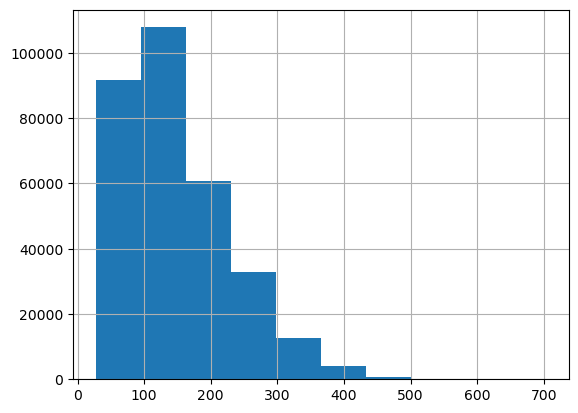

In [24]:
pd.Series(len_js).hist()

<AxesSubplot:>

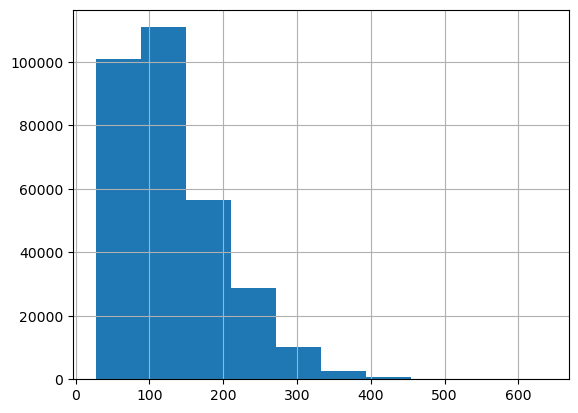

In [25]:
pd.Series(len_ks).hist()

In [27]:
(pd.Series(len_js)>512).sum()

55

In [28]:
(pd.Series(len_ks)>512).sum()

20

In [31]:
x = load_dataset('stanfordnlp/SHP')

Using custom data configuration stanfordnlp--SHP-a63343e047b69134


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /home/charipol/.cache/huggingface/datasets/stanfordnlp___json/stanfordnlp--SHP-a63343e047b69134/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
x['train'][0]

{'post_id': 'himc90',
 'domain': 'askacademia_train',
 'upvote_ratio': 0.99,
 'history': 'In an interview right before receiving the 2013 Nobel prize in physics, Peter Higgs stated that he wouldn\'t be able to get an academic job today, because he wouldn\'t be regarded as productive enough. > By the time he retired in 1996, he was uncomfortable with the new academic culture. "After I retired it was quite a long time before I went back to my department. I thought I was well out of it. It wasn\'t my way of doing things any more. Today I wouldn\'t get an academic job. It\'s as simple as that. I don\'t think I would be regarded as productive enough."  Another interesting quote from the article is the following:  > He doubts a similar breakthrough could be achieved in today\'s academic culture, because of the expectations on academics to collaborate and keep churning out papers. He said: "It\'s difficult to imagine how I would ever have enough peace and quiet in the present sort of climate 

In [39]:
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    PreTrainedTokenizerBase,
    HfArgumentParser,
)
from transformers.utils import PaddingStrategy
from typing import Optional, Union, List, Dict, Any
import evaluate
from dataclasses import dataclass, field
import torch.nn as nn
import numpy as np
import wandb
import multiprocessing
cpu_cores = multiprocessing.cpu_count()

@dataclass
class ScriptArguments:
    """
    These arguments vary depending on how many GPUs you have, what their capacity and features are, and what size model you want to train.
    """
    num_train_epochs: Optional[int] = field(default=2)
    resume_from_checkpoint: Optional[bool] = field(default=False)
    #multigpu stuff
    local_rank: Optional[int] = field(default=0)
    deepspeed: Optional[str] = field(default=None)
    per_device_train_batch_size: Optional[int] = field(default=8)
    per_device_eval_batch_size: Optional[int] = field(default=8)
    gradient_accumulation_steps: Optional[int] = field(default=2)
    #lr stuff
    learning_rate: Optional[int] = field(default=3e-4)
    weight_decay: Optional[int] = field(default=0.001)
    lr_scheduler_type: Optional[str] = field(default="cosine")
    warmup_ratio: Optional[int] = field(default=0.1)
    #logging stuff
    wandb_project: Optional[str] = field(default="php_reward_model")
    logging_steps: Optional[int] = field(default=100)
    #eval stuff
    eval_steps: Optional[int] = field(default=1000)
    #model and dataset
    model_name: Optional[str] = field(default="xlm-roberta-base")
    dataset_name: Optional[str] = field(default="pythainlp/php_reward")
    better_column: Optional[str] = field(default="human_ref_1st")
    worse_column: Optional[str] = field(default="human_ref_2nd")
    train_split_name: Optional[str] = field(default="train") 
    eval_split_name: Optional[str] = field(default="test") 
    #tokenizer stuff
    max_length: Optional[int] = field(default=512)
    #half precision stuff
    bf16: Optional[bool] = field(default=True,)

script_args = ScriptArguments()

# initialize wandb with project and run names
wandb.init(project=script_args.wandb_project, 
           name=f"{script_args.wandb_project}_{wandb.util.generate_id()}")

# Load the human comparisons dataset for tuning the reward model.
ds = load_dataset(script_args.dataset_name)

# Define the training args. Needs to be done before the model is loaded if you are using deepspeed.
training_args = TrainingArguments(
    output_dir=f"{script_args.model_name}_reward_model",
    learning_rate=script_args.learning_rate,
    per_device_train_batch_size=script_args.per_device_train_batch_size,
    per_device_eval_batch_size=script_args.per_device_eval_batch_size,
    num_train_epochs=script_args.num_train_epochs,
    weight_decay=script_args.weight_decay,
    lr_scheduler_type=script_args.lr_scheduler_type,
    warmup_ratio=script_args.warmup_ratio,
    evaluation_strategy="steps",
    eval_steps=script_args.eval_steps,
    logging_steps=script_args.logging_steps,
    save_strategy="epoch",
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    deepspeed=script_args.deepspeed,
    local_rank=script_args.local_rank,
    label_names=[],
)

# Load the value-head model and tokenizer.
tokenizer = AutoTokenizer.from_pretrained(script_args.model_name)
model = AutoModelForSequenceClassification.from_pretrained(script_args.model_name, num_labels=1)

# Need to do this for gpt2, because it doesn't have an official pad token.
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Tokenize the dataset.
def preprocess_function(examples):
    tokenized_j = tokenizer(examples[script_args.better_column], 
                            max_length=script_args.max_length, truncation=True)
    tokenized_k = tokenizer(examples[script_args.worse_column], 
                            max_length=script_args.max_length, truncation=True)
    return {
        "input_ids_j": tokenized_j["input_ids"],
        "attention_mask_j": tokenized_j["attention_mask"],
        "input_ids_k": tokenized_k["input_ids"],
        "attention_mask_k": tokenized_k["attention_mask"],
    }

tokenized_ds = ds.map(preprocess_function, batched=True, 
                      num_proc=cpu_cores, 
                      remove_columns=None)

wandb: Currently logged in as: cstorm125. Use `wandb login --relogin` to force relogin


Using custom data configuration pythainlp--php_reward-0d092a94ca410d9e
Found cached dataset parquet (/home/charipol/.cache/huggingface/datasets/pythainlp___parquet/pythainlp--php_reward-0d092a94ca410d9e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│    62 ds = load_dataset(script_args.dataset_name)                                                │
│    63                                                                                            │
│    64 # Define the training args. Needs to be done before the model is loaded if you are using   │
│ ❱  65 training_args = TrainingArguments(                                                         │
│    66 │   output_dir=f"{script_args.model_name}_reward_model",                                   │
│    67 │   learning_rate=script_args.learning_rate,                                               │
│    68 │   per_device_train_batch_size=script_args.per_device_train_batch_size,                   │
│ in __init__                                                                                      │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/training_args.py:1129 in      │
│ __post_init__                                                                                    │
│                                                                                                  │
│   1126 │   │   if (                                                                              │
│   1127 │   │   │   self.framework == "pt"                                                        │
│   1128 │   │   │   and is_torch_available()                                                      │
│ ❱ 1129 │   │   │   and (self.device.type != "cuda")                                              │
│   1130 │   │   │   and (get_xla_device_type(self.device) != "GPU")                               │
│   1131 │   │   │   and (self.fp16 or self.fp16_full_eval)                                        │
│   1132 │   │   ):                                                                                │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/utils/import_utils.py:1017 in │
│ wrapper                                                                                          │
│                                                                                                  │
│   1014 │   @wraps(func)                                                                          │
│   1015 │   def wrapper(*args, **kwargs):                                                         │
│   1016 │   │   if is_torch_available():                                                          │
│ ❱ 1017 │   │   │   return func(*args, **kwargs)                                                  │
│   1018 │   │   else:                                                                             │
│   1019 │   │   │   raise ImportError(f"Method `{func.__name__}` requires PyTorch.")              │
│   1020                                                                                           │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/training_args.py:1498 in      │
│ device                                                                                           │
│                                                                                                  │
│   1495 │   │   """                                                                               │
│   1496 │   │   The device used by this process.                                                  │
│   1497 │   │   """                                         

In [42]:
training_args = TrainingArguments(
    output_dir=f"{script_args.model_name}_reward_model",
    learning_rate=script_args.learning_rate,
    per_device_train_batch_size=script_args.per_device_train_batch_size,
    per_device_eval_batch_size=script_args.per_device_eval_batch_size,
    num_train_epochs=script_args.num_train_epochs,
    weight_decay=script_args.weight_decay,
    lr_scheduler_type=script_args.lr_scheduler_type,
    warmup_ratio=script_args.warmup_ratio,
    evaluation_strategy="steps",
    eval_steps=script_args.eval_steps,
    logging_steps=script_args.logging_steps,
    save_strategy="epoch",
    gradient_accumulation_steps=script_args.gradient_accumulation_steps,
    deepspeed=script_args.deepspeed,
    local_rank=script_args.local_rank,
    label_names=[],
)

@dataclass
class RewardDataCollatorWithPadding:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = script_args.max_length
    pad_to_multiple_of: Optional[int] = None
    return_tensors: str = "pt"

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        features_j = []
        features_k = []
        for feature in features:
            features_j.append({"input_ids": feature["input_ids_j"], 
                               "attention_mask": feature["attention_mask_j"]})
            features_k.append({"input_ids": feature["input_ids_k"], 
                               "attention_mask": feature["attention_mask_k"]})
        batch_j = self.tokenizer.pad(
            features_j,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch_k = self.tokenizer.pad(
            features_k,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch = {
            "input_ids_j": batch_j["input_ids"],
            "attention_mask_j": batch_j["attention_mask"],
            "input_ids_k": batch_k["input_ids"],
            "attention_mask_k": batch_k["attention_mask"],
            "return_loss": True,
        }
        return batch


# Define the metric that we'll use for validation.
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, _ = eval_pred
    # Here, predictions is rewards_j and rewards_k.
    # We want to see how much of the time rewards_j > rewards_k.
    predictions = np.argmax(predictions, axis=0)
    labels = np.zeros(predictions.shape) #first one always better
    return accuracy.compute(predictions=predictions, references=labels)


class RewardTrainer(Trainer):
    # Define how to compute the reward loss.
    def compute_loss(self, model, inputs, return_outputs=False):
        rewards_j = model(input_ids=inputs["input_ids_j"], 
                          attention_mask=inputs["attention_mask_j"])[0]
        rewards_k = model(input_ids=inputs["input_ids_k"], 
                          attention_mask=inputs["attention_mask_k"])[0]
        loss = -nn.functional.logsigmoid(rewards_j - rewards_k).mean()
        if return_outputs:
            return loss, {"rewards_j": rewards_j, "rewards_k": rewards_k}
        return loss

# Train the model, woohoo.
trainer = RewardTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds[script_args.train_split_name],
    eval_dataset=tokenized_ds[script_args.eval_split_name],
    compute_metrics=compute_metrics,
    data_collator=RewardDataCollatorWithPadding(tokenizer=tokenizer),
)

trainer.train(script_args.resume_from_checkpoint)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱  1 training_args = TrainingArguments(                                                          │
│    2 │   output_dir=f"{script_args.model_name}_reward_model",                                    │
│    3 │   learning_rate=script_args.learning_rate,                                                │
│    4 │   per_device_train_batch_size=script_args.per_device_train_batch_size,                    │
│ in __init__                                                                                      │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/training_args.py:1129 in      │
│ __post_init__                                                                                    │
│                                                                                                  │
│   1126 │   │   if (                                                                              │
│   1127 │   │   │   self.framework == "pt"                                                        │
│   1128 │   │   │   and is_torch_available()                                                      │
│ ❱ 1129 │   │   │   and (self.device.type != "cuda")                                              │
│   1130 │   │   │   and (get_xla_device_type(self.device) != "GPU")                               │
│   1131 │   │   │   and (self.fp16 or self.fp16_full_eval)                                        │
│   1132 │   │   ):                                                                                │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/utils/import_utils.py:1017 in │
│ wrapper                                                                                          │
│                                                                                                  │
│   1014 │   @wraps(func)                                                                          │
│   1015 │   def wrapper(*args, **kwargs):                                                         │
│   1016 │   │   if is_torch_available():                                                          │
│ ❱ 1017 │   │   │   return func(*args, **kwargs)                                                  │
│   1018 │   │   else:                                                                             │
│   1019 │   │   │   raise ImportError(f"Method `{func.__name__}` requires PyTorch.")              │
│   1020                                                                                           │
│                                                                                                  │
│ /home/charipol/miniconda3/lib/python3.9/site-packages/transformers/training_args.py:1498 in      │
│ device                                                                                           │
│                                                                                                  │
│   1495 │   │   """                                                                               │
│   1496 │   │   The device used by this process.                                                  │
│   1497 │   │   """                                                                               │
│ ❱ 1498 │   │   return self._setup_devices                                                        │
│   1499 │                                                                                         │
│   1500 │   @property                                       